# WAMLAP Phase 2: FCNN Experiments

This notebook documents the iterative process of building a data-driven Fully Connected Neural Network (FCNN) to learn the behavior of a simple harmonic oscillator. Each experiment is contained in its own section to show the evolution from a simple, underfitting model to a more robust, final baseline.

In [1]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- TensorFlow ---
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [3]:
# IMPORTANT: Replace this with the name of your undamped (zeta=0) data file.
filename = "2025-10-09_121653_sho_zeta0p0_omega1p0.csv" # <-- UPDATE THIS
filepath = f"../data/processed/{filename}"

df = pd.read_csv(filepath)
print(f"Loaded data from: {filename}")

Loaded data from: 2025-10-09_121653_sho_zeta0p0_omega1p0.csv


## Experiment 1: Naive FCNN

**Hypothesis:** A simple FCNN can learn the oscillation from the `time` input.

**Setup:**
-   Input Feature (X): `time`
-   Architecture: 2 hidden layers with 128 neurons each.

In [4]:
# For this experiment, our input X is just the time column.
X_time = df[['time']].values
y = df[['position']].values

In [5]:
# Define and compile the first model
model_1 = keras.Sequential([
    layers.Dense(128, activation='tanh', input_shape=[1]),
    layers.Dense(128, activation='tanh'),
    layers.Dense(1)
])
model_1.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
print("--- Training Model 1: Naive FCNN ---")
history_1 = model_1.fit(X_time, y, epochs=500, validation_split=0.2, verbose=0, callbacks=[EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)])
print("Training complete.")

/Users/jamesmclean/miniforge3/envs/WAMLAP/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-09 14:59:12.324791: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-10-09 14:59:12.325079: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-10-09 14:59:12.325114: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-10-09 14:59:12.325406: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-09 14:59:12.325428: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.c

--- Training Model 1: Naive FCNN ---


2025-10-09 14:59:13.696864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Training complete.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


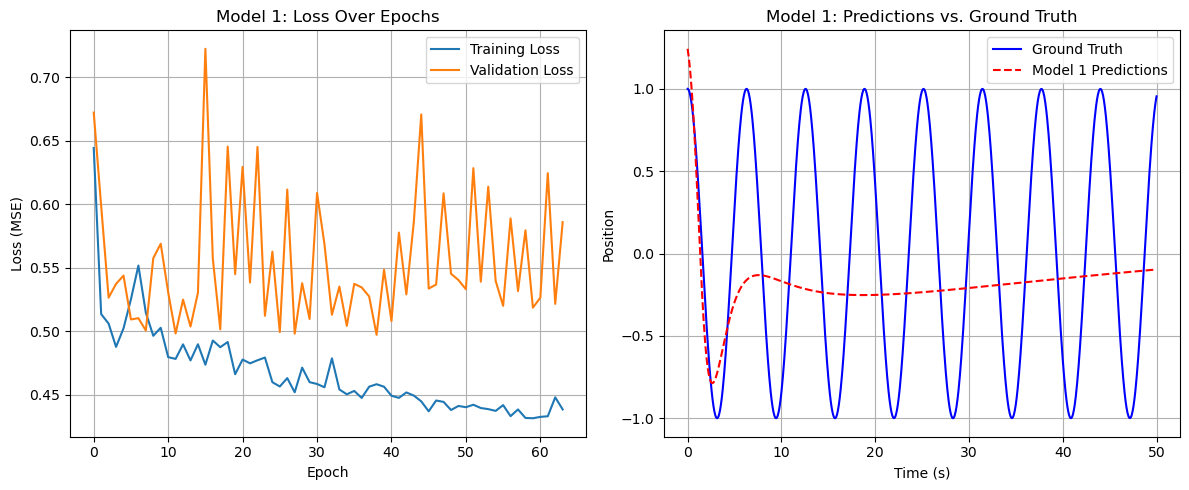

Model 1 - Final RMSE: 0.7043


In [7]:
# --- 1. Plot the training history ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Model 1: Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# --- 2. Plot the predictions ---
plt.subplot(1, 2, 2)
predictions_1 = model_1.predict(X_time)
plt.plot(df['time'], y, label='Ground Truth', color='blue')
plt.plot(df['time'], predictions_1, label='Model 1 Predictions', color='red', linestyle='--')
plt.title('Model 1: Predictions vs. Ground Truth')
plt.xlabel('Time (s)')
plt.ylabel('Position')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 3. Calculate the final error ---
final_mse_1 = model_1.evaluate(X_time, y, verbose=0)
final_rmse_1 = np.sqrt(final_mse_1)
print(f"Model 1 - Final RMSE: {final_rmse_1:.4f}")

## Experiment 2: Improved FCNN with Feature Engineering

**Diagnosis from Exp 1:** The naive model underfit badly. The `time` feature is not informative enough.

**Hypothesis:** Providing cyclical, frequency-informed features (`sin(ωt)`, `cos(ωt)`) and adding regularization will allow the model to learn the function successfully.

**Setup:**
-   Input Features (X): `sin_time_omega`, `cos_time_omega`
-   Architecture: 2x128 with L2 regularization and Dropout.

In [8]:
# Define the known angular frequency of the data
omega0 = 1.0

# Create and select the new engineered features
df['sin_time_omega'] = np.sin(omega0 * df['time'])
df['cos_time_omega'] = np.cos(omega0 * df['time'])
X_eng = df[['sin_time_omega', 'cos_time_omega']].values

In [10]:
# Configure Early Stopping for this experiment
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)

# Train the model
print("\n--- Training Model 2: Improved FCNN ---")
history_2 = model_2.fit(
    X_eng,
    y,
    epochs=500,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping_callback] # Use the callback
)


--- Training Model 2: Improved FCNN ---
Epoch 1/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1190 - val_loss: 0.0251
Epoch 2/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0351 - val_loss: 0.0133
Epoch 3/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0278 - val_loss: 0.0138
Epoch 4/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0252 - val_loss: 0.0126
Epoch 5/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0222 - val_loss: 0.0130
Epoch 6/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0210 - val_loss: 0.0123
Epoch 7/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0201 - val_loss: 0.0122
Epoch 8/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0196 - val_loss: 0.0122
Epoch 9/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0182 - val_loss: 0.0119
Epoch 10/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0179 - val_loss: 0.0116
Epoch 11/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0177 - val_loss: 0.0117
Epoch 12/50

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


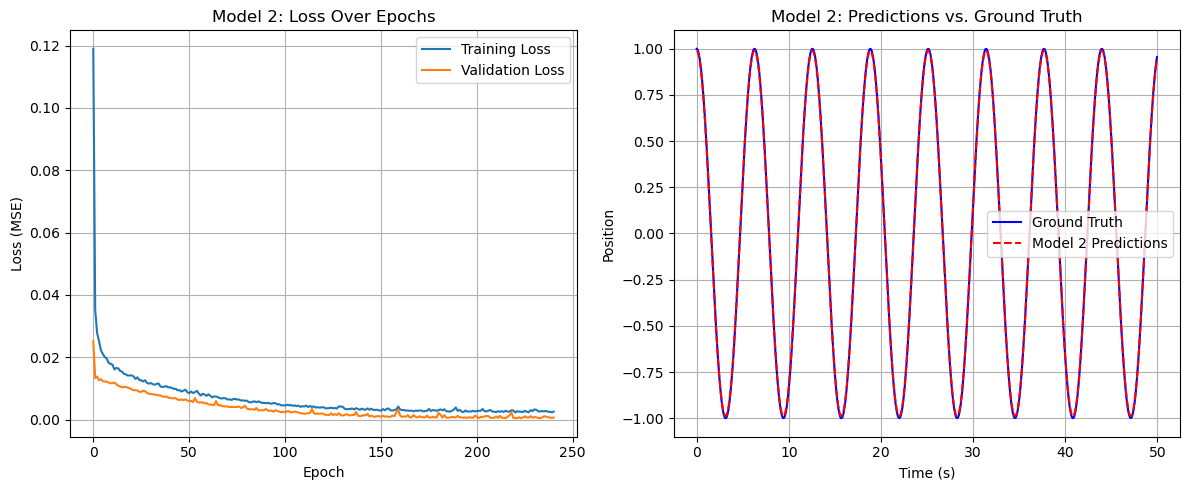

Model 2 - Final RMSE on the full dataset: 0.021109


In [11]:
# --- 1. Plot the training history ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Model 2: Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# --- 2. Plot the predictions ---
plt.subplot(1, 2, 2)
predictions_2 = model_2.predict(X_eng)
plt.plot(df['time'], y, label='Ground Truth', color='blue')
plt.plot(df['time'], predictions_2, label='Model 2 Predictions', color='red', linestyle='--')
plt.title('Model 2: Predictions vs. Ground Truth')
plt.xlabel('Time (s)')
plt.ylabel('Position')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 3. Calculate the final error ---
final_mse_2 = model_2.evaluate(X_eng, y, verbose=0)
final_rmse_2 = np.sqrt(final_mse_2)
print(f"Model 2 - Final RMSE on the full dataset: {final_rmse_2:.6f}")